<a href="https://colab.research.google.com/github/skyshine460/Datascience_notebook/blob/main/deep_liearning_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [517]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [518]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [519]:
print(tf.__version__)

2.17.0


In [520]:
tf.random.set_seed(42)
np.random.seed(42)

In [521]:
df = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/train.csv")
test = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/test.csv")
sample_submit = pd.read_csv("/content/drive/MyDrive/SOTA Challenge(アップル 引越し需要予測)/sample_submit.csv", header=None)
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1


In [522]:
df.tail()

,datetime,y,client,close,price_am,price_pm
2096,2016-03-27,94,1,0,5,4
2097,2016-03-28,86,1,0,4,4
2098,2016-03-29,98,1,0,4,4
2099,2016-03-30,99,1,0,5,4
2100,2016-03-31,105,1,0,5,4


In [523]:
df.shape

(2101, 6)

In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2101 non-null   object
 1   y         2101 non-null   int64 
 2   client    2101 non-null   int64 
 3   close     2101 non-null   int64 
 4   price_am  2101 non-null   int64 
 5   price_pm  2101 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 98.6+ KB


In [525]:
df["datetime"] = pd.to_datetime(df["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2101 non-null   datetime64[ns]
 1   y         2101 non-null   int64         
 2   client    2101 non-null   int64         
 3   close     2101 non-null   int64         
 4   price_am  2101 non-null   int64         
 5   price_pm  2101 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 98.6 KB


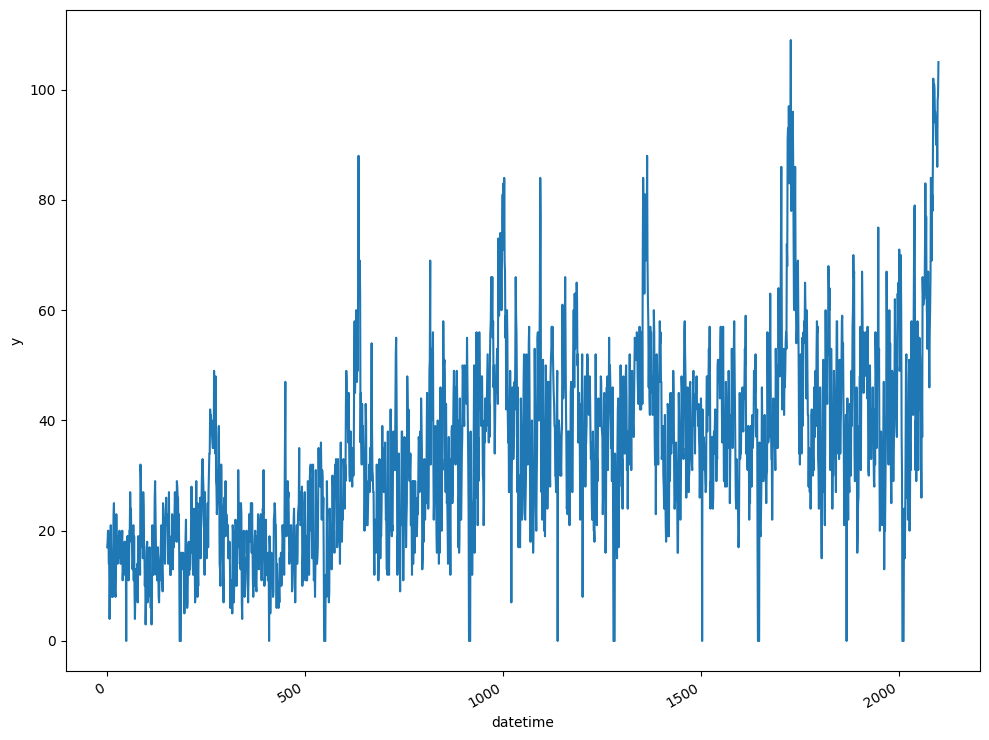

In [526]:
fig, ax = plt.subplots()

ax.plot(df['y'])
ax.set_xlabel('datetime')
ax.set_ylabel('y')

# plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

# 特徴量エンジニアリングとデータの分割

In [527]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
datetime,2101,2013-05-16 00:00:00.000000256,2010-07-01 00:00:00,2011-12-08 00:00:00,2013-05-16 00:00:00,2014-10-23 00:00:00,2016-03-31 00:00:00,NaN
y,2101.0,34.096621,0.0,21.0,32.0,45.0,109.0,17.476234
client,2101.0,0.098049,0.0,0.0,0.0,0.0,1.0,0.297451
close,2101.0,0.012851,0.0,0.0,0.0,0.0,1.0,0.112658
price_am,2101.0,0.614469,-1.0,0.0,0.0,1.0,5.0,1.12794
price_pm,2101.0,0.390766,-1.0,0.0,0.0,1.0,5.0,0.975456


In [528]:
# タイムステップに変更
df['timestamp_s'] = df['datetime'].astype('int64') // 10**9
df = df.drop(['datetime'], axis=1)

In [529]:
df.head()

,y,client,close,price_am,price_pm,timestamp_s
0,17,0,0,-1,-1,1277942400
1,18,0,0,-1,-1,1278028800
2,20,0,0,-1,-1,1278115200
3,20,0,0,-1,-1,1278201600
4,14,0,0,-1,-1,1278288000


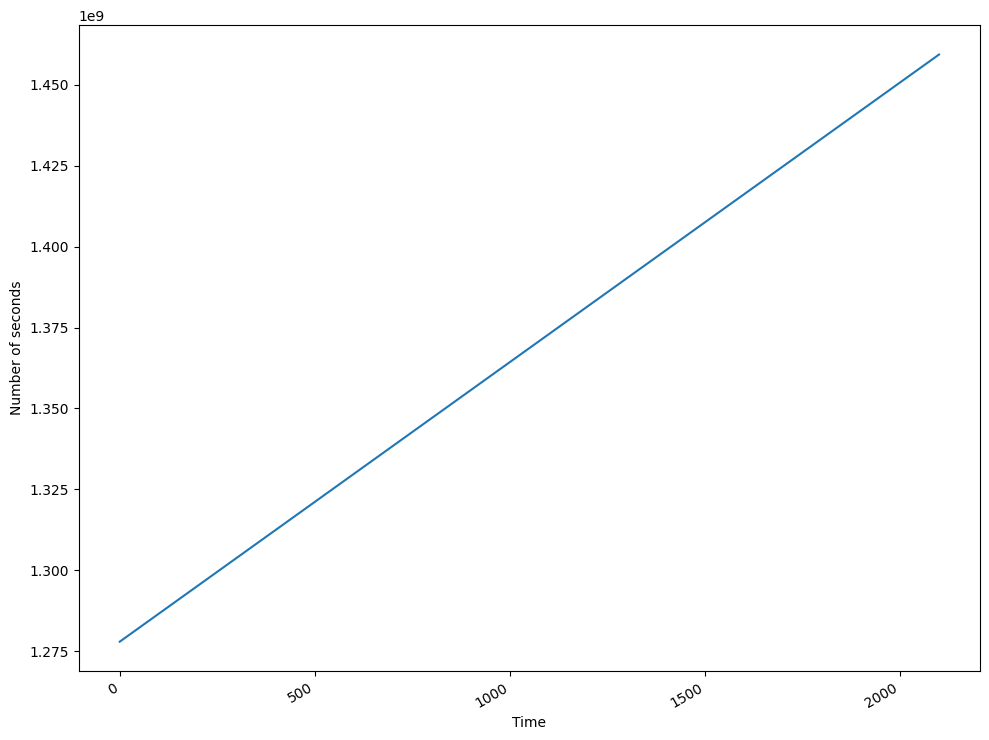

In [530]:
# タイムステップが直線で絵ががれていることを確認
fig, ax = plt.subplots()

ax.plot(df['timestamp_s'])
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

# plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

In [531]:
# 仮でテストデータを分ける
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((1470, 6), (420, 6), (211, 6))

異なるスケールの特徴量の影響緩和させるため、データのすべての値が0~1になるようにスケーリングする必要がある。（正規化の必要はない）

In [532]:
# MinMaxScalerでスケーリング
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

# データウィンドウ処理(DateWindowing)

データウィンドウ処理は時系列でデータ店のシーケンスを定義して、入力データとラベル（予測値と比較する目的変数）を明確にするプロセス。

DataWindowクラスの実装


In [533]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        # 訓練、検証、テストデータのデータフレームを設定
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # ラベルとして使用するカラムが指定されている場合、それらのカラムのインデックスを取得
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        # 全カラムのインデックスを取得
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # 入力とラベルの幅、シフト値を設定
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # ウィンドウサイズ（入力データ幅 + シフト）
        self.total_window_size = input_width + shift

        # 入力の範囲（スライスオブジェクト）を作成
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        # ラベルの開始位置と範囲を設定（スライスオブジェクト）
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        # 入力とラベルを分割（時系列データの特定の範囲を切り出し）
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        # ラベルカラムが指定されている場合、指定されたカラムのみを抽出
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # 入力とラベルの形状を設定（不定長次元の設定）
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='y', max_subplots=3):
        # サンプルバッチから入力データとラベルを取得
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        # 最大で指定された数のプロットを作成
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')

            # 入力データをプロット
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            # ラベルカラムのインデックスを取得
            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            # ラベルデータをプロット
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)

            # モデルが指定されている場合、予測結果をプロット
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        plt.show()  # プロットを表示

    def make_dataset(self, data):
        # データをnumpy配列に変換し、時系列データセットを作成
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,  # 入力データ
            targets=None,  # ターゲットなし（自分で分割）
            sequence_length=self.total_window_size,  # ウィンドウサイズ
            sequence_stride=1,  # ウィンドウをずらす幅
            shuffle=True,  # データをシャッフル
            batch_size=32  # バッチサイズ
        )

        # データセットを入力とラベルに分割するマッピング処理
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        # 訓練データ用のデータセットを作成
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        # 検証データ用のデータセットを作成
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        # テストデータ用のデータセットを作成
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        # サンプルバッチを取得（初回アクセス時のみ生成）
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))  # 訓練データからバッチを取得
            self._sample_batch = result
        return result

# シングルステップのベースラインモデル

シングルステップモデルの入力は1つの時間ステップであり、出力は次の時間ステップの予測値である。

入力の幅:1、ラベルの幅:1、シフト:1。
可視化用に、入力の幅:30、ラベルの幅:30、シフト:1も作成する。

In [534]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['y'])
wide_window = DataWindow(input_width=30, label_width=30, shift=1, label_columns=['y'])

ベースラインのクラスを作成する

In [535]:
import tensorflow as tf
from tensorflow.keras.models import Model

class Baseline(Model):
    def __init__(self, label_index=None):
        # 親クラス(Model)の初期化を呼び出し、ラベルインデックスを設定
        super().__init__()
        self.label_index = label_index  # ラベルインデックスは、予測対象のカラムのインデックス

    def call(self, inputs):
        # モデルの前向き計算処理 (TensorFlowモデルの `call` メソッドに対応)
        # 入力データに基づいて予測を行う

        if self.label_index is None:
            # ラベルインデックスが指定されていない場合、入力をそのまま返す
            return inputs

        elif isinstance(self.label_index, list):
            # 複数のラベルインデックスがリストで指定されている場合
            tensors = []  # 各ラベルを格納するためのリストを作成
            for index in self.label_index:
                # リスト内の各インデックスに対して操作を行う
                result = inputs[:, :, index]  # 指定されたラベルインデックスに対応するデータを抽出
                result = result[:, :, tf.newaxis]  # チャンネル次元を追加して形状を変更
                tensors.append(result)  # 結果をリストに追加
            return tf.concat(tensors, axis=-1)  # 最終的にすべてのラベルを結合し、1つのテンソルとして返す

        # ラベルインデックスが単一の場合、対応するデータを抽出して返す
        result = inputs[:, :, self.label_index]  # 指定されたラベルインデックスに対応するデータを抽出
        return result[:, :, tf.newaxis]  # チャンネル次元を追加して形状を変更し、返す

損失関数と評価指標を指定する。
今回の評価指標はMAEなので、損失関数としては、MAE, MSE, Huber Loss, Quantile Lossが有効である。

Huber Loss：
MAEとMSEのバランスを取った損失関数。小さな誤差にはMSEのように扱い、大きな誤差にはMAEのように扱う。外れ値（outliers）に対してMAEほど敏感ではなく、安定したモデル学習が可能。また、外れ値が少ない場合に有効で、MAEよりもなだらかな損失関数で、MSEの特徴も持ち合わせている。

Quantile Loss（分位点損失）：

回帰問題で特定の分位点にフォーカスしたい場合に適している。特定の分位点（予測の中央値やパーセンタイル）に注目する場合に有効。MAEを一般化した形で、より柔軟なエラーモデルの学習が可能。

In [536]:
# カラム名とインデックスを対応させる辞書を作成
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Baselineモデルを作成し、予測対象となるカラム 'y' のインデックスを指定
baseline_last = Baseline(label_index=column_indices['y'])

# # モデルをコンパイルして予測値を生成（損失関数：MSE、評価指標：MAEを指定）
# baseline_last.compile(loss=tf.keras.losses.MeanSquaredError(),  metrics=[tf.keras.metrics.MeanAbsoluteError()])

# モデルをコンパイルして予測値を生成（損失関数：Huber、評価指標：MAEを指定）
from tensorflow.keras.losses import Huber
baseline_last.compile(loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [537]:
# 検証データ、テストデータでのベースラインでのMAEを格納
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0878  


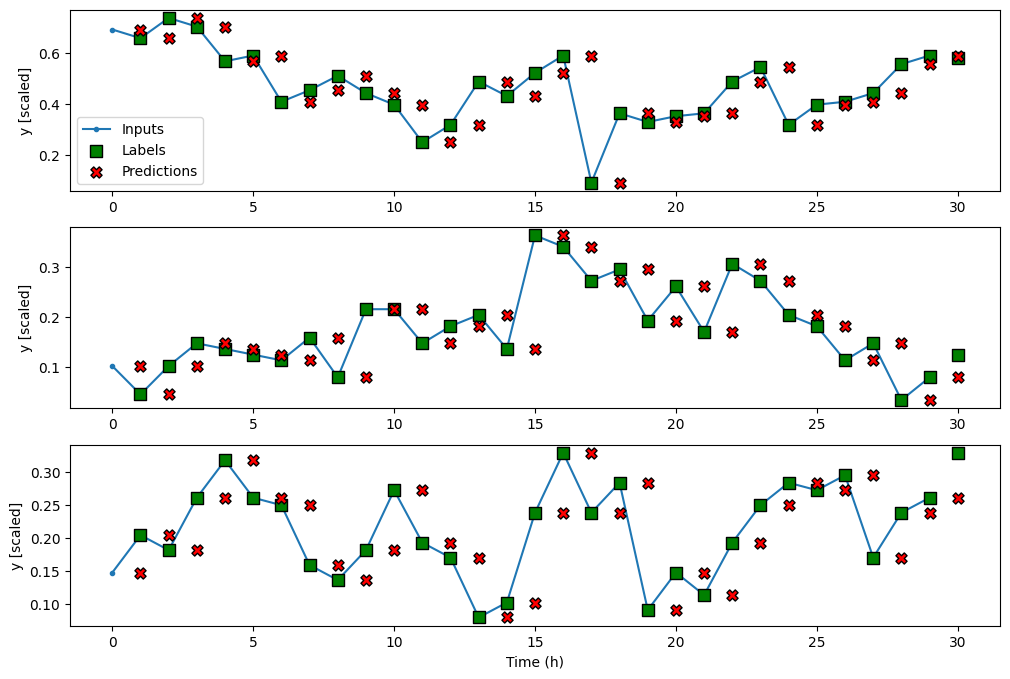

In [538]:
wide_window.plot(baseline_last)

予測値は各時間ステップの✖ば単に最後の既知の値。ベースラインが想定通り機能できていることが確認できる。

In [539]:
print(performance['Baseline - Last'][1])

0.10357143729925156


# マルチステップのベースラインモデル

30日間分の入力が与えられたら、次の30日間の実績を予測する。

In [540]:
multi_window = DataWindow(input_width=30, label_width=30, shift=30, label_columns=['y'])

In [541]:
class MultiStepLastBaseline(Model):  # ベースラインモデルを定義するクラス
    def __init__(self, label_index=None):  # コンストラクタでラベルのインデックスを受け取る（デフォルトはNone）
        super().__init__()  # 親クラス（Model）のコンストラクタを呼び出す
        self.label_index = label_index  # ラベルのインデックスをインスタンス変数として保存

    def call(self, inputs):  # モデルが呼び出されたときに実行される処理（TensorFlowで必須）
        if self.label_index is None:  # ラベルのインデックスがNoneの場合
            # 入力の最後のタイムステップ（[-1:,:]）のデータを30回繰り返して返す
            # tf.tileはテンソルを繰り返す関数で、[1, 30, 1] はバッチ内、時間軸、フィーチャー軸の繰り返し回数
            return tf.tile(inputs[:, -1:, :], [1, 30, 1])

        # ラベルインデックスが指定されている場合、特定のインデックスからのデータを24回繰り返して返す
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 30, 1])

In [542]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['y'])

# ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
from tensorflow.keras.losses import Huber
ms_baseline_last.compile(loss=Huber(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 - mean_absolute_error: 0.3830  


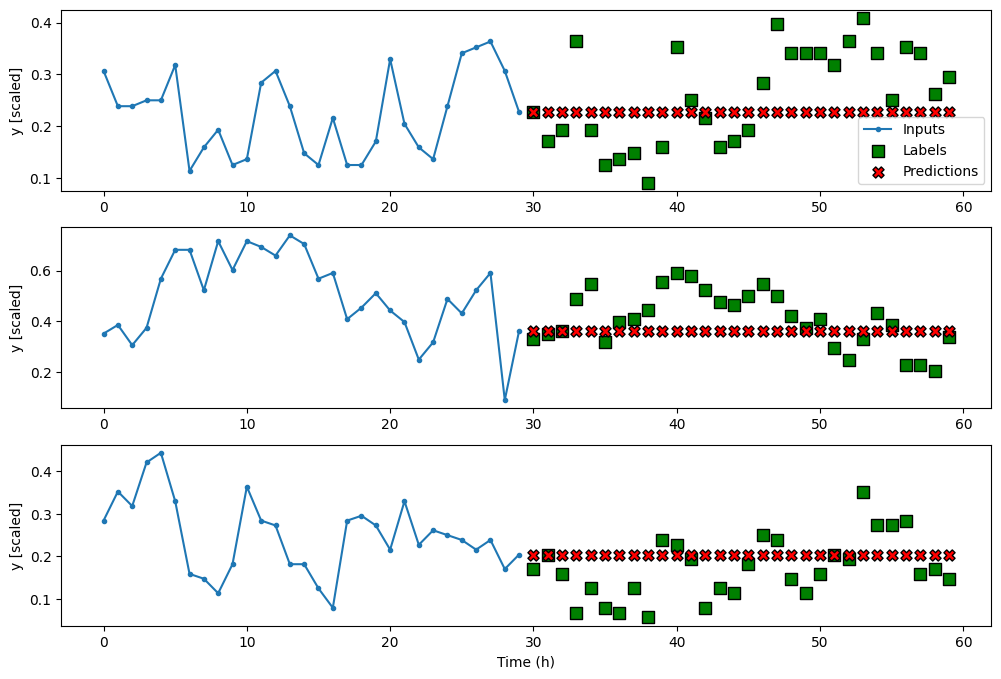

In [543]:
multi_window.plot(ms_baseline_last)

3日のステップに対して、最後の日の予測値を30日間出力している。ベースラインしては想定通りに機能している。

In [544]:
print(ms_performance['Baseline - Last'][1])

0.45107951760292053


次に30日間の予測を行う。予測値は前の30日間のリピートとなっている。

In [545]:
class RepeatBaseline(Model):  # ベースラインモデルを定義するクラス
    def __init__(self, label_index=None):  # コンストラクタでラベルのインデックスを受け取る（デフォルトはNone）
        super().__init__()  # 親クラス（Model）のコンストラクタを呼び出す
        self.label_index = label_index  # ラベルのインデックスをインスタンス変数として保存

    def call(self, inputs):  # モデルが呼び出されたときに実行される処理
        # 入力の特定のインデックスからのデータを全タイムステップにわたって返す
        # inputs[:, :, self.label_index:] は、全バッチと全タイムステップに対して、指定されたラベルインデックス以降のフィーチャーを抽出する
        return inputs[:, :, self.label_index:]

In [546]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['y'])

# ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])
from tensorflow.keras.losses import Huber
ms_baseline_repeat.compile(loss=Huber(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1066 - mean_absolute_error: 0.3894  


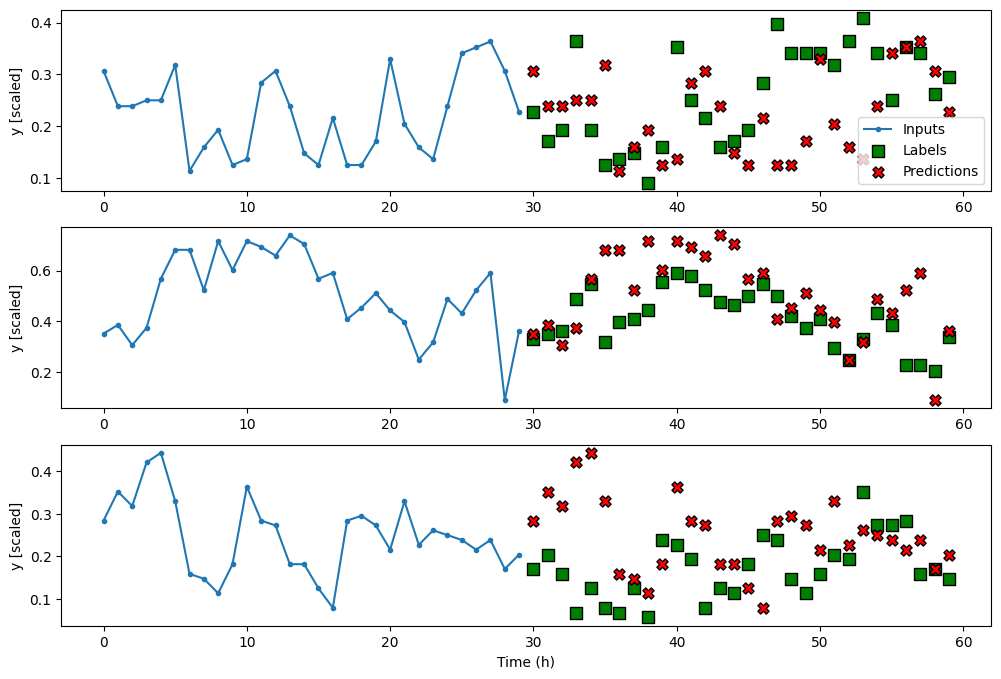

In [547]:
multi_window.plot(ms_baseline_repeat)

予測値が前の30日間となっているベースラインができた

In [548]:
print(ms_performance['Baseline - Repeat'][1])

0.45374795794487


# 線形モデルの実装

# シングルステップの線形モデル

時間tにおける各カラムの値に重みwを割り当てて、t+1の目的変数を予測する。

In [549]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    # EarlyStoppingコールバックを定義し、バリデーションロスが改善されなくなった場合に学習を停止する
    early_stopping = EarlyStopping(monitor='val_loss',  # 監視する指標はバリデーションロス
                                   patience=patience,  # 改善が見られないエポック数
                                   mode='min')  # バリデーションロスを最小化する方向で監視

    # モデルをコンパイルする
    model.compile(loss=Huber(),  # 損失関数を指定
                  optimizer=Adam(),  # Adamオプティマイザを使用
                  metrics=[MeanAbsoluteError()])  # 評価指標を指定

    # モデルを訓練する
    history = model.fit(window.train,  # 訓練データ
                        epochs=max_epochs,  # 最大エポック数
                        validation_data=window.val,  # バリデーションデータ
                        callbacks=[early_stopping])  # EarlyStoppingコールバックを適用

    return history  # 訓練履歴を返す

In [550]:
linear = Sequential([Dense(units=1)])  # SequentialモデルではDense層（深層）の数を指定できる

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0193 - mean_absolute_error: 0.1491 - val_loss: 0.0704 - val_mean_absolute_error: 0.3117
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - mean_absolute_error: 0.1367 - val_loss: 0.0714 - val_mean_absolute_error: 0.3172
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.1300 - val_loss: 0.0652 - val_mean_absolute_error: 0.3005
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - mean_absolute_error: 0.1250 - val_loss: 0.0612 - val_mean_absolute_error: 0.2902
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - mean_absolute_error: 0.1251 - val_loss: 0.0554 - val_mean_absolute_error: 0.2733
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - mean_absolute_error: 0.1222 - val_loss: 0.0530 - val_mean_absolute_error: 0.2667
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - mean_absolute_error: 0.1188 - val_loss: 0.048

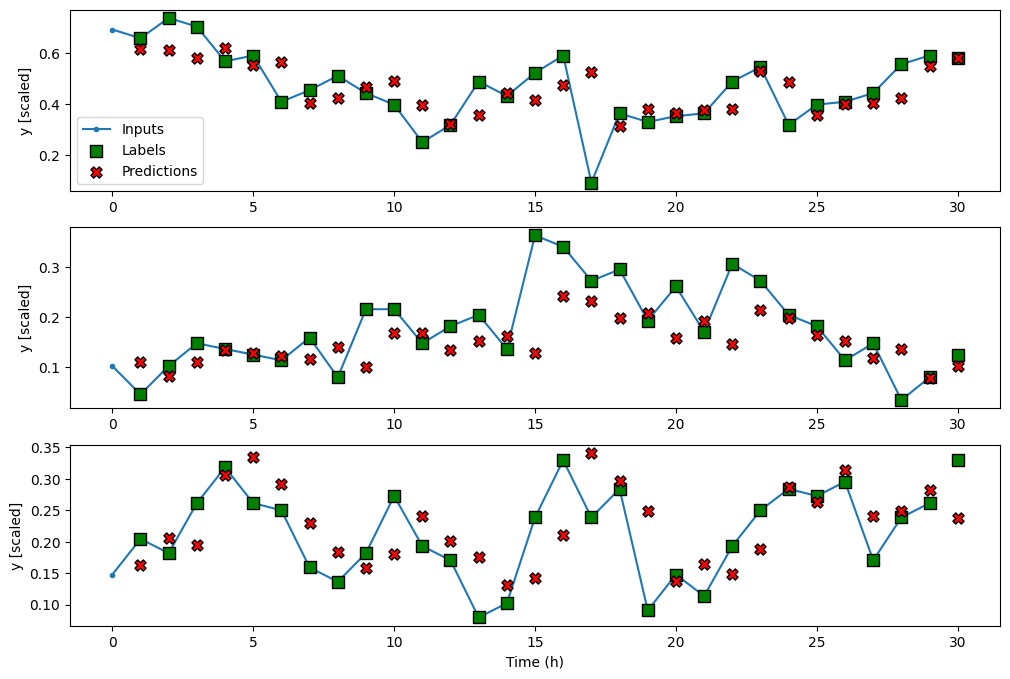

In [551]:
wide_window.plot(linear)

# マルチステップの線形モデル

各カラムの30日間のデータを収集して1つの層で結合し、次の30日間を予測する

In [552]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0642 - mean_absolute_error: 0.3137 - val_loss: 0.0765 - val_mean_absolute_error: 0.3513
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0355 - mean_absolute_error: 0.2181 - val_loss: 0.0427 - val_mean_absolute_error: 0.2403
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213 - mean_absolute_error: 0.1557 - val_loss: 0.0263 - val_mean_absolute_error: 0.1704
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.1255 - val_loss: 0.0198 - val_mean_absolute_error: 0.1415
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0122 - mean_absolute_error: 0.1173 - val_loss: 0.0173 - val_mean_absolute_error: 0.1320
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mean_absolute_error: 0.1135 - val_loss: 0.0163 - val_mean_absolute_error: 0.1289
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - mean_absolute_error: 0.1125 - val_loss: 0.015

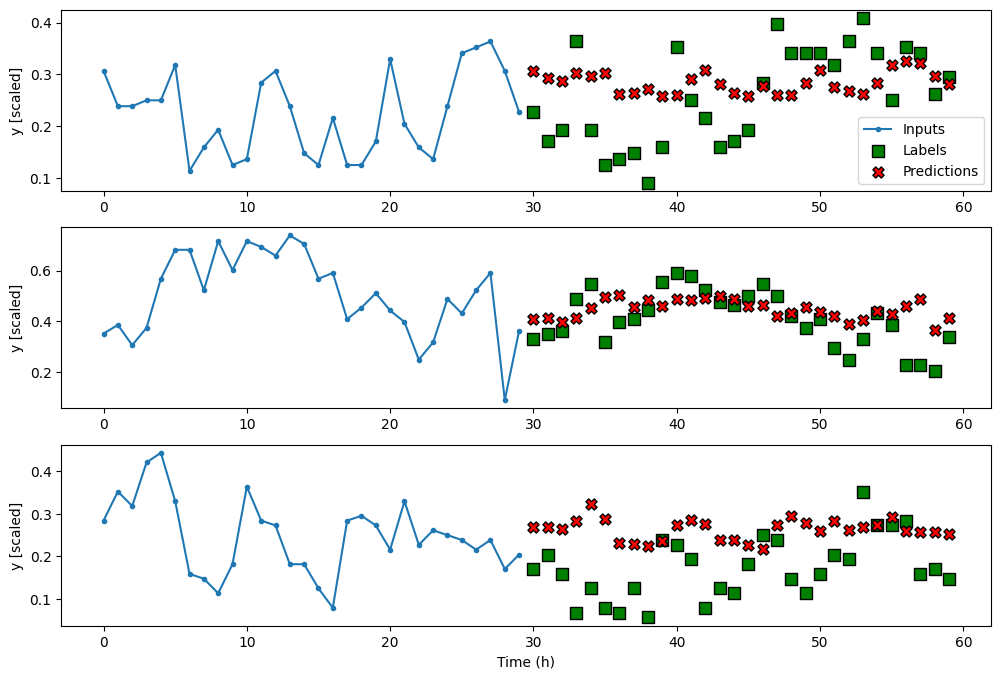

In [553]:
multi_window.plot(ms_linear)

# ディープニューラルネットワーク(DNN)の実装

DNNではニューラルネットワークに隠れ層を追加する事によってより良い結果を得ることができる

# シングルステップのDNNモデル

In [554]:
dense = Sequential([  # Sequentialモデルを定義する
    Dense(units=64, activation='relu'),  # 64ユニットを持つ全結合層、ReLU活性化関数を使用
    Dense(units=64, activation='relu'),  # 2層目
    Dense(units=1)  # 出力層：1ユニットの全結合層（回帰問題などで単一の予測値を出力）
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0296 - mean_absolute_error: 0.1821 - val_loss: 0.0077 - val_mean_absolute_error: 0.0943
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.0775 - val_loss: 0.0073 - val_mean_absolute_error: 0.0946
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0684 - val_loss: 0.0068 - val_mean_absolute_error: 0.0907
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0692 - val_loss: 0.0071 - val_mean_absolute_error: 0.0932
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0679 - val_loss: 0.0073 - val_mean_absolute_error: 0.0951
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0685 - val_loss: 0.0064 - val_mean_absolute_error: 0.0873
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0675 - val_loss: 0.00

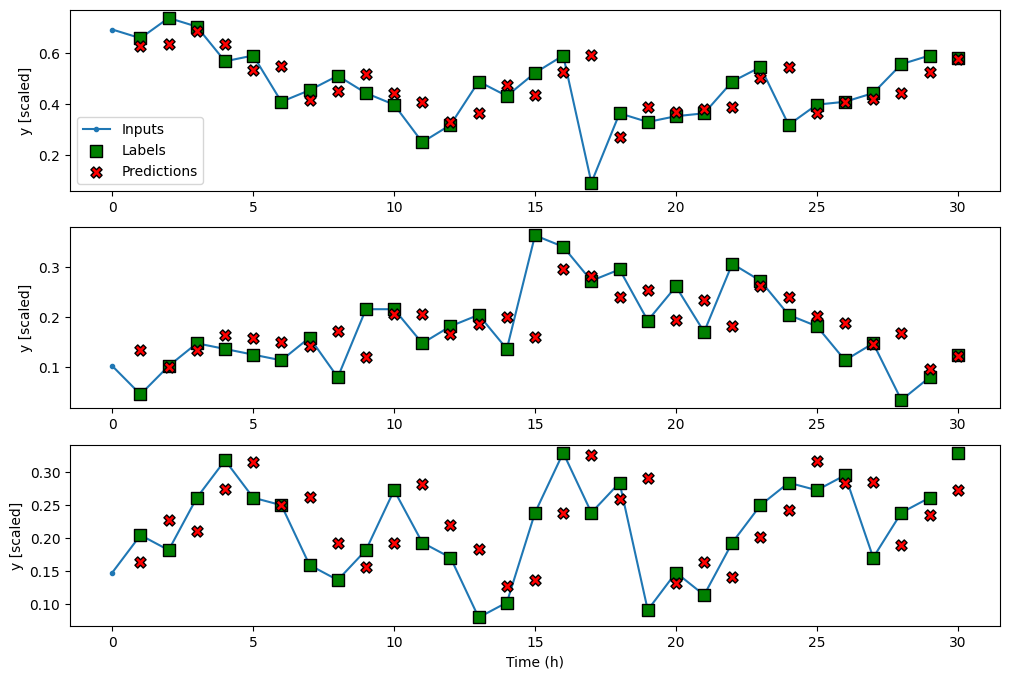

In [555]:
wide_window.plot(dense)

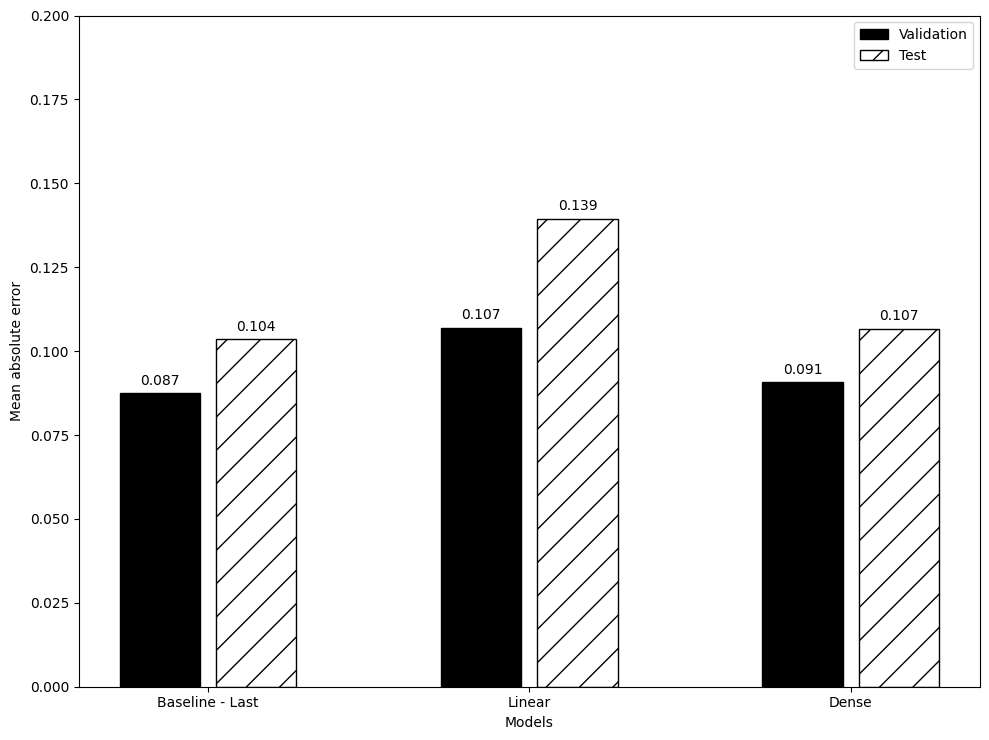

In [556]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.2)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

# マルチステップのDNNモデル

In [557]:
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0502 - mean_absolute_error: 0.2635 - val_loss: 0.0158 - val_mean_absolute_error: 0.1290
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0105 - mean_absolute_error: 0.1106 - val_loss: 0.0165 - val_mean_absolute_error: 0.1420
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0094 - mean_absolute_error: 0.1032 - val_loss: 0.0160 - val_mean_absolute_error: 0.1389
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mean_absolute_error: 0.1030 - val_loss: 0.0160 - val_mean_absolute_error: 0.1384
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mean_absolute_error: 0.1381 


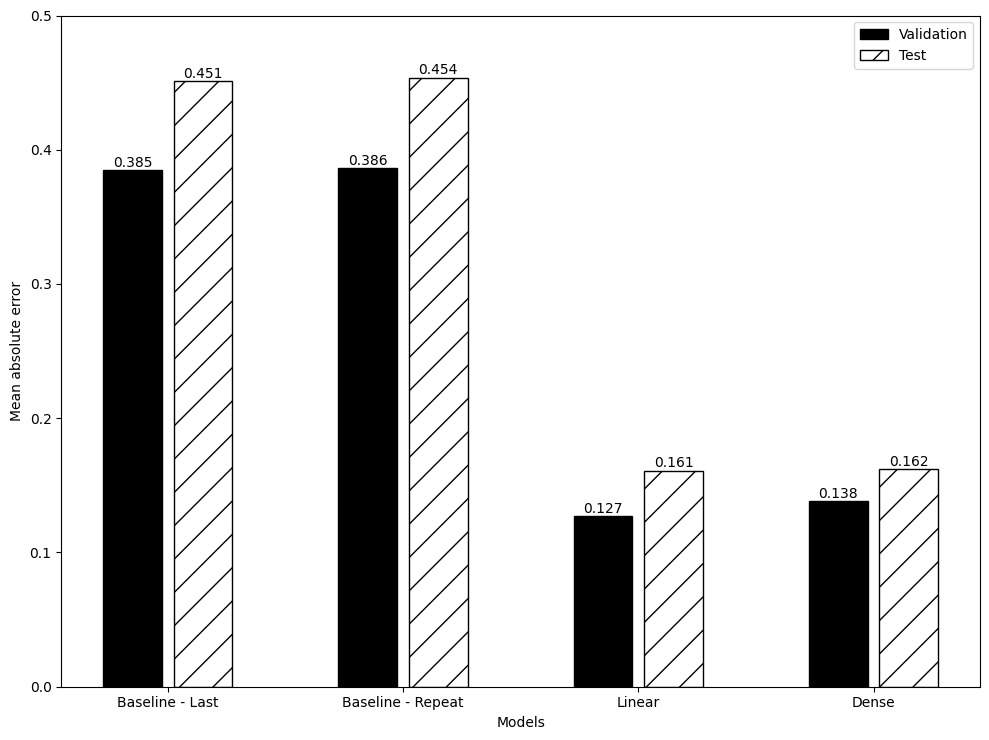

In [558]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

# 長短期記憶（LSTM: Long Short-Term Memory）の実装

LSTMは勾配消失問題（時系列の古いデータの影響度が小さくなってしまうこと）を回避するためのRNNアーキテクチャにセル状態を追加したもの。

# シングルステップのLSTMモデル

In [559]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['y'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['y'])

In [560]:
mae_val = [0.087, 0.149, 0.085]
mae_test = [0.104, 0.234, 0.104]

In [561]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),  # LSTM層：32ユニット。シーケンスのすべてのタイムステップで出力を返す（return_sequences=True）
    Dense(units=1)  # 出力層
])


history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0221 - mean_absolute_error: 0.1632 - val_loss: 0.0145 - val_mean_absolute_error: 0.1313
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0085 - mean_absolute_error: 0.1004 - val_loss: 0.0110 - val_mean_absolute_error: 0.1112
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0071 - mean_absolute_error: 0.0914 - val_loss: 0.0104 - val_mean_absolute_error: 0.1098
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0063 - mean_absolute_error: 0.0860 - val_loss: 0.0095 - val_mean_absolute_error: 0.1059
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0058 - mean_absolute_error: 0.0818 - val_loss: 0.0087 - val_mean_absolute_error: 0.1013
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0053 - mean_absolute_error: 0.0787 - val_loss: 0.0078 - val_mean_absolute_error: 0.0957
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0051 - mean_absolute_error: 0.0767 - val_loss

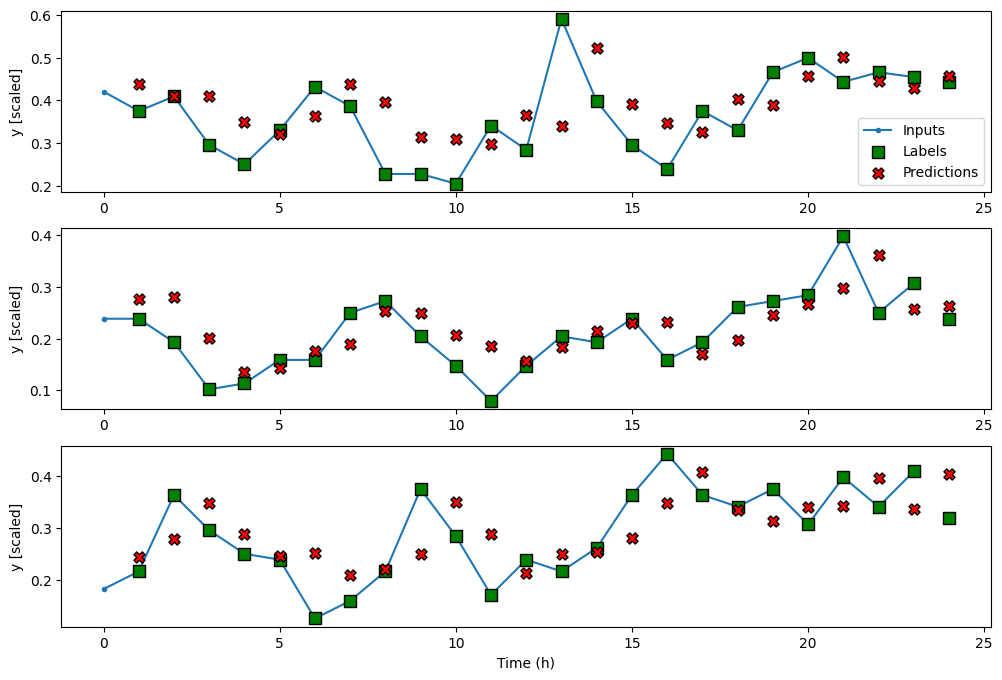

In [562]:
wide_window.plot(lstm_model)

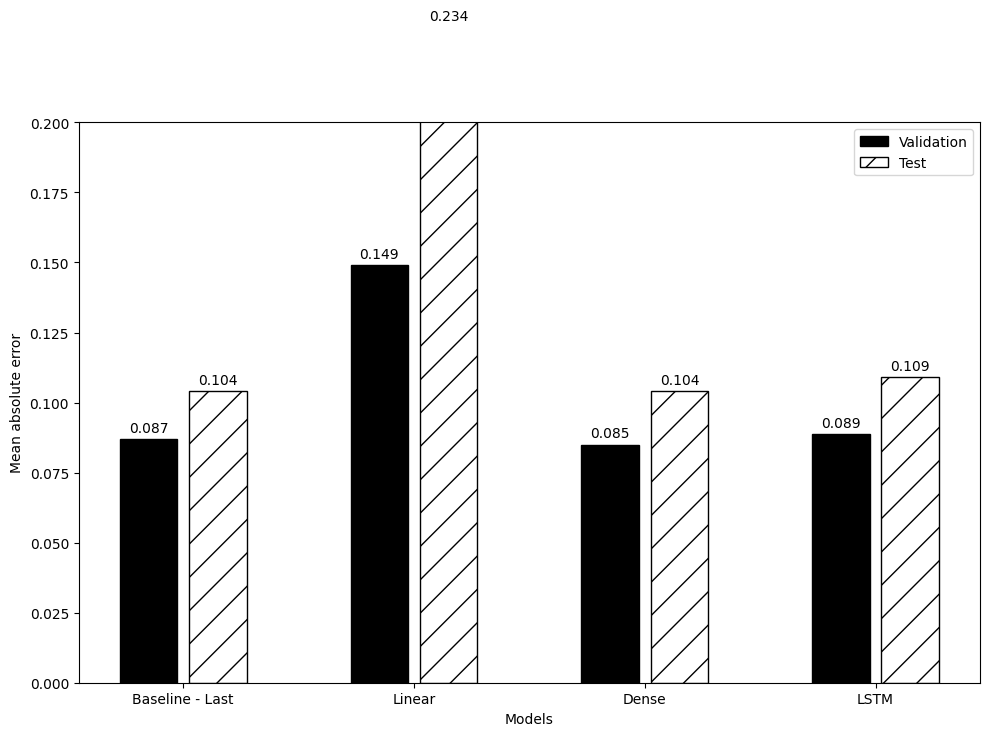

In [563]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.2)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# マルチステップのLSTMモデル

In [564]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['y'])

In [565]:
mae_val = [0.358, 0.386, 0.127, 0.134]
mae_test = [0.451, 0.454, 0.161, 0.160]

In [566]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0551 - mean_absolute_error: 0.2820 - val_loss: 0.0299 - val_mean_absolute_error: 0.1800
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0160 - mean_absolute_error: 0.1359 - val_loss: 0.0213 - val_mean_absolute_error: 0.1505
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0126 - mean_absolute_error: 0.1209 - val_loss: 0.0204 - val_mean_absolute_error: 0.1563
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0117 - mean_absolute_error: 0.1158 - val_loss: 0.0177 - val_mean_absolute_error: 0.1404
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0110 - mean_absolute_error: 0.1120 - val_loss: 0.0177 - val_mean_absolute_error: 0.1447
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0108 - mean_absolute_error: 0.1118 - val_loss: 0.0161 - val_mean_absolute_error: 0.1337
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0102 - mean_absolute_error: 0.1081 - val_loss

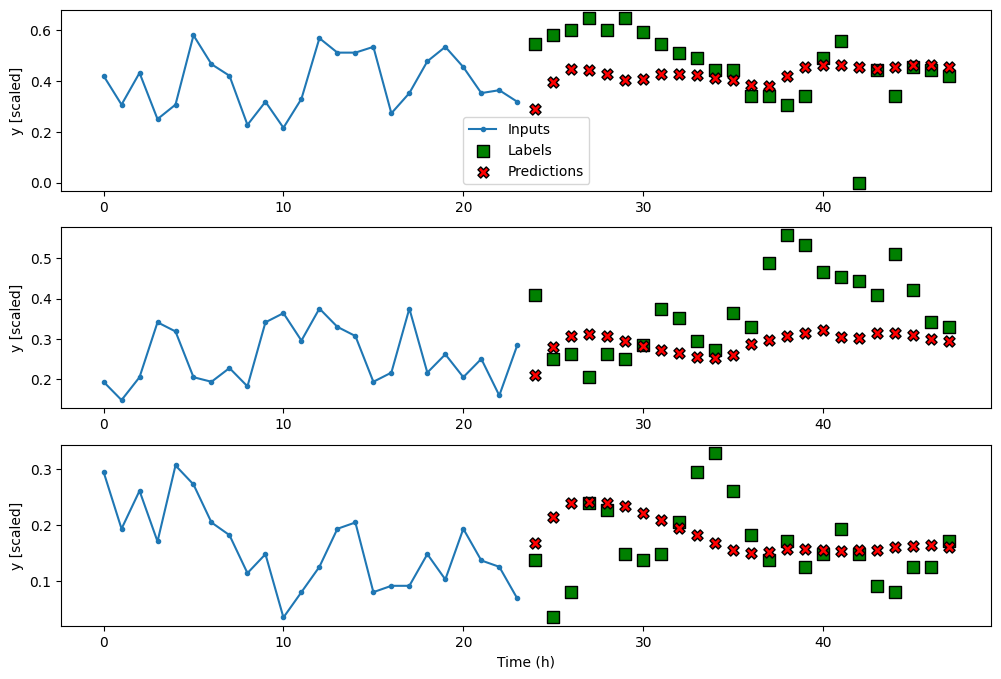

In [567]:
multi_window.plot(ms_lstm_model)

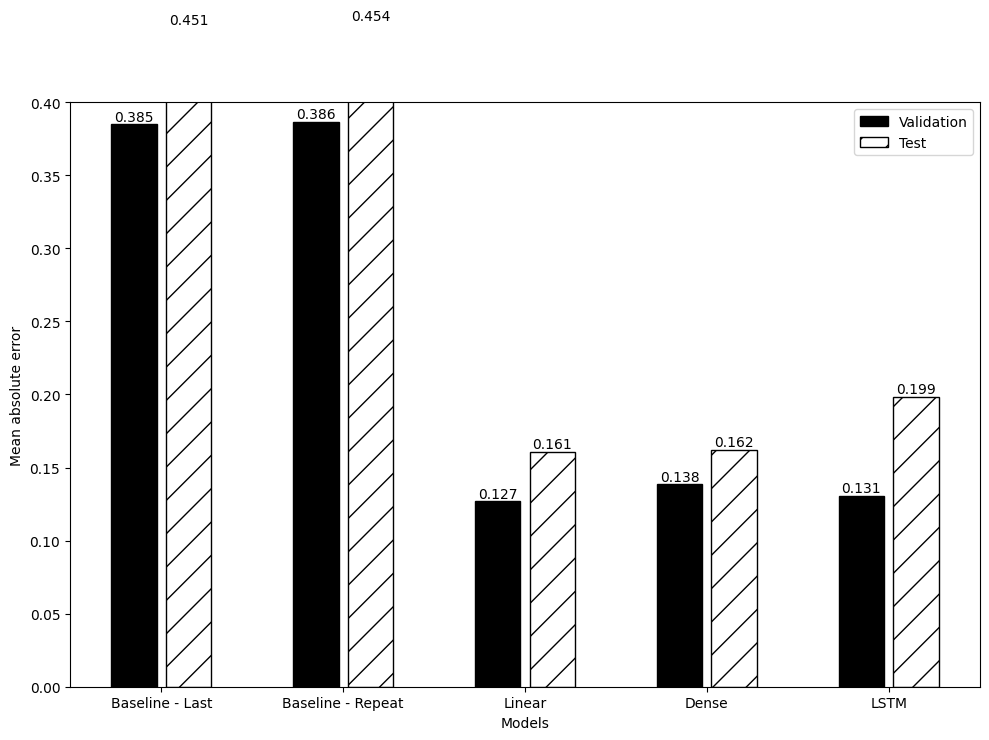

In [568]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# 畳み込みニューラルネットワーク（CNN）

CNNは畳み込み演算を利用するディープラーニングアーキテクチャ。
畳み込み演算では縮約された特徴量セットの作成が可能なため、ネットワークを正則化し、過剰適合を回避し、入力を効果的にフィルタリングする手段となる。

# シングルステップのCNNモデル、CNN+LSTMモデル

In [569]:
KERNEL_WIDTH = 3 # カーネルの長さ
LABEL_WIDTH = 30 # ラベル（出力）の幅
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1 # 入力の長さ＝出力の長さ＋カーネルの長さ−１

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['y'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['y'])

In [570]:
mae_val = [0.087, 0.149, 0.085, 0.094]
mae_test = [0.104, 0.234, 0.104, 0.131]

In [571]:
cnn_model = Sequential([
    Conv1D(filters=32,  # 32個のフィルタを使用する1次元畳み込み層
           kernel_size=(KERNEL_WIDTH,),  # カーネルの幅（フィルタのサイズ）を設定
           activation='relu'),  # ReLU活性化関数を使用。非線形性を導入し、負の値を0にする
    Dense(units=32, activation='relu'),  # 全結合層：32ユニットを持ち、ReLU活性化関数を使用
    Dense(units=1)  # 出力層：1ユニット
])


history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0427 - mean_absolute_error: 0.2248 - val_loss: 0.0176 - val_mean_absolute_error: 0.1381
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0065 - mean_absolute_error: 0.0853 - val_loss: 0.0143 - val_mean_absolute_error: 0.1276
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - mean_absolute_error: 0.0773 - val_loss: 0.0127 - val_mean_absolute_error: 0.1212
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0747 - val_loss: 0.0144 - val_mean_absolute_error: 0.1242
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0713 - val_loss: 0.0122 - val_mean_absolute_error: 0.1170
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - mean_absolute_error: 0.0706 - val_loss: 0.0124 - val_mean_absolute_error: 0.1159
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - mean_absolute_error: 0.0721 - val_loss: 0.0

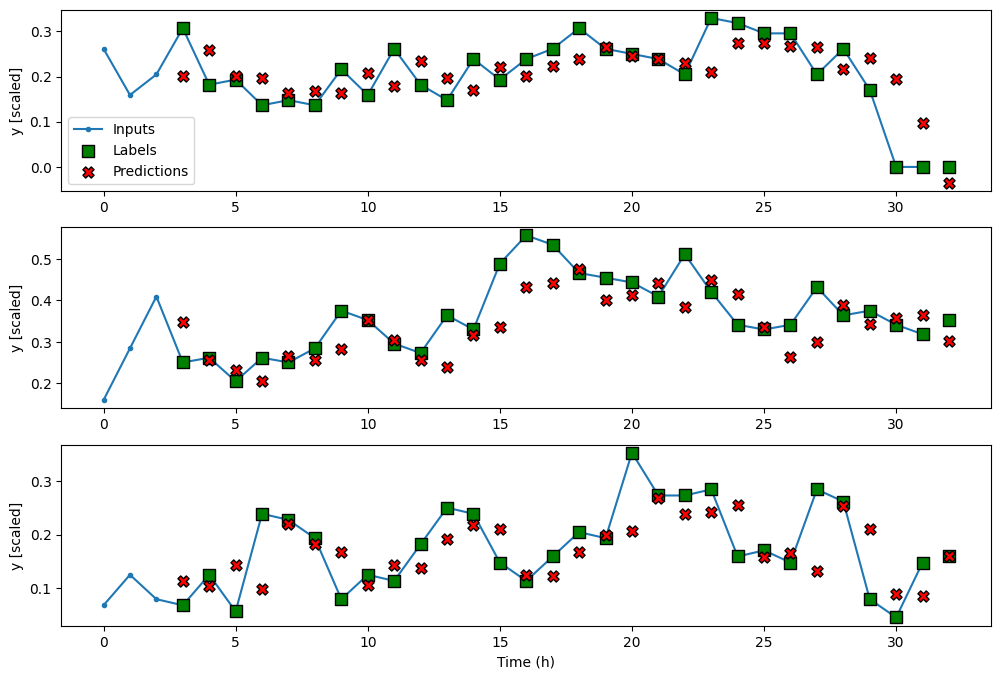

In [572]:
wide_conv_window.plot(cnn_model)

CNNとLSTM結合
入力シーケンスをフィルタリングしてからLSTMを行う。
Conv1D層のあとにLSTMを2層配置。

In [573]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0548 - mean_absolute_error: 0.2828 - val_loss: 0.0169 - val_mean_absolute_error: 0.1516
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0080 - mean_absolute_error: 0.0998 - val_loss: 0.0097 - val_mean_absolute_error: 0.1059
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - mean_absolute_error: 0.0874 - val_loss: 0.0088 - val_mean_absolute_error: 0.1030
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - mean_absolute_error: 0.0794 - val_loss: 0.0075 - val_mean_absolute_error: 0.0932
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - mean_absolute_error: 0.0763 - val_loss: 0.0074 - val_mean_absolute_error: 0.0938
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mean_absolute_error: 0.0734 - val_loss: 0.0076 - val_mean_absolute_error: 0.0958
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044 - mean_absolute_error: 0.0711 - val_loss: 0

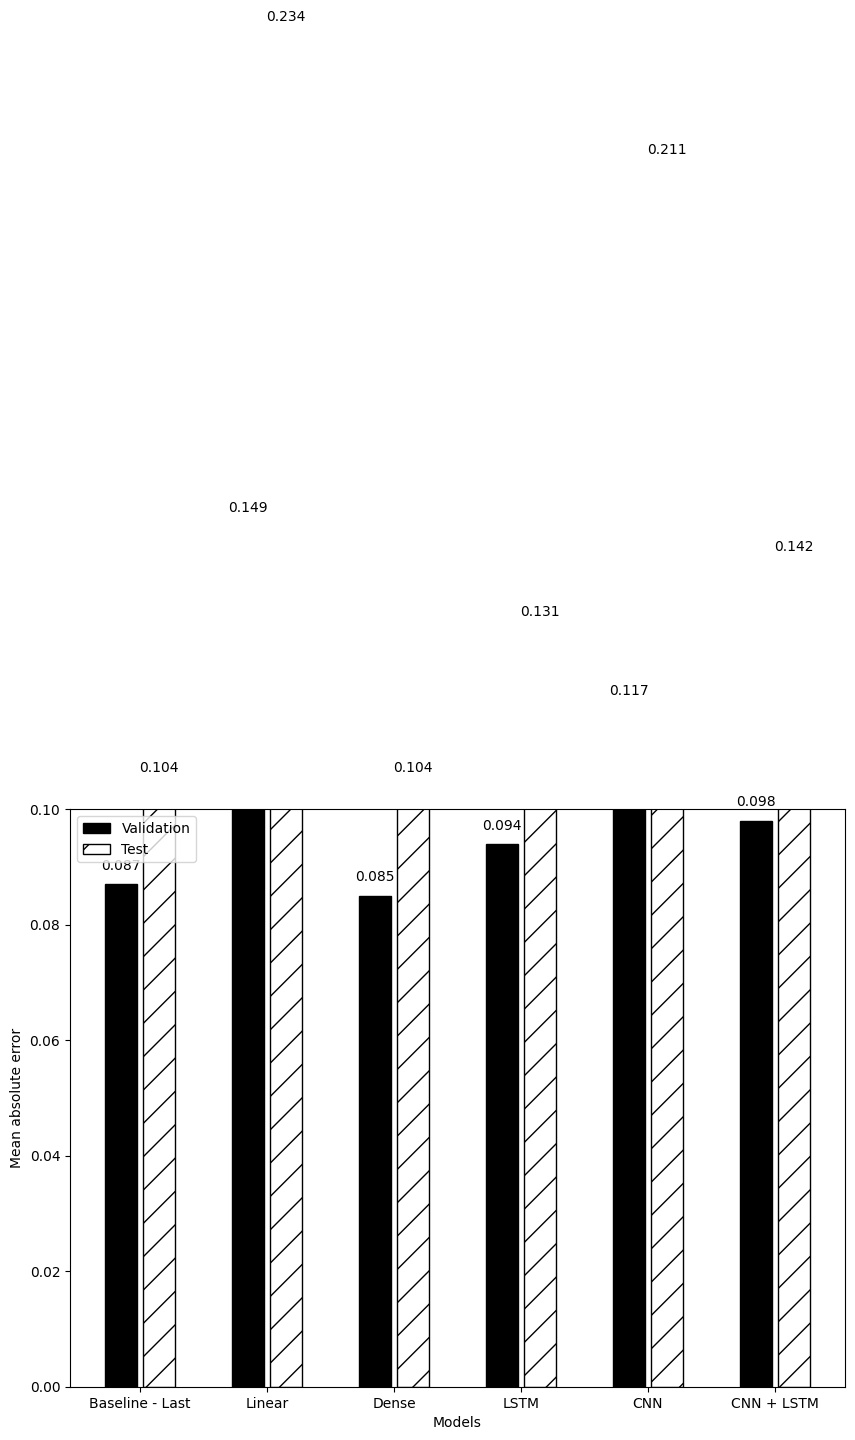

In [574]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# マルチステップのCNNモデル、CNN+LSTMモデル

In [575]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['y'])

In [577]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0562 - mean_absolute_error: 0.2847 - val_loss: 0.0222 - val_mean_absolute_error: 0.1645
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - mean_absolute_error: 0.1181 - val_loss: 0.0188 - val_mean_absolute_error: 0.1499
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mean_absolute_error: 0.1084 - val_loss: 0.0189 - val_mean_absolute_error: 0.1537
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.1062 - val_loss: 0.0171 - val_mean_absolute_error: 0.1444
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.1044 - val_loss: 0.0178 - val_mean_absolute_error: 0.1497
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - mean_absolute_error: 0.1049 - val_loss: 0.0175 - val_mean_absolute_error: 0.1472
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.1046 - val_loss: 0.01

In [578]:
print(ms_val_performance['CNN'][1])
print(ms_performance['CNN'][1])

0.14879214763641357
0.1792721450328827


In [579]:
ms_mae_val

[0.38484784960746765,
 0.38639184832572937,
 0.12695357203483582,
 0.13839904963970184,
 0.13064181804656982]

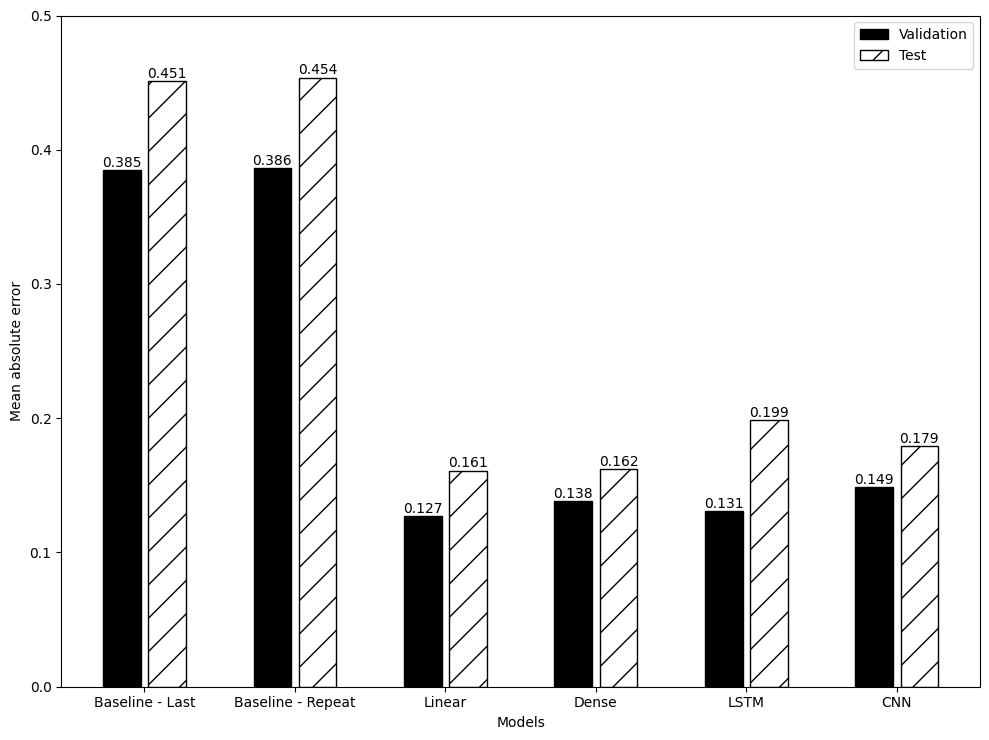

In [580]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [581]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0513 - mean_absolute_error: 0.2692 - val_loss: 0.0128 - val_mean_absolute_error: 0.1289
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0075 - mean_absolute_error: 0.0979 - val_loss: 0.0093 - val_mean_absolute_error: 0.1031
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - mean_absolute_error: 0.0872 - val_loss: 0.0082 - val_mean_absolute_error: 0.0979
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - mean_absolute_error: 0.0812 - val_loss: 0.0083 - val_mean_absolute_error: 0.0997
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - mean_absolute_error: 0.0764 - val_loss: 0.0082 - val_mean_absolute_error: 0.0998
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - mean_absolute_error: 0.0710 - val_loss: 0.0087 - val_mean_absolute_error: 0.1040
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mean_absolute_error: 0.0713 - val_loss:

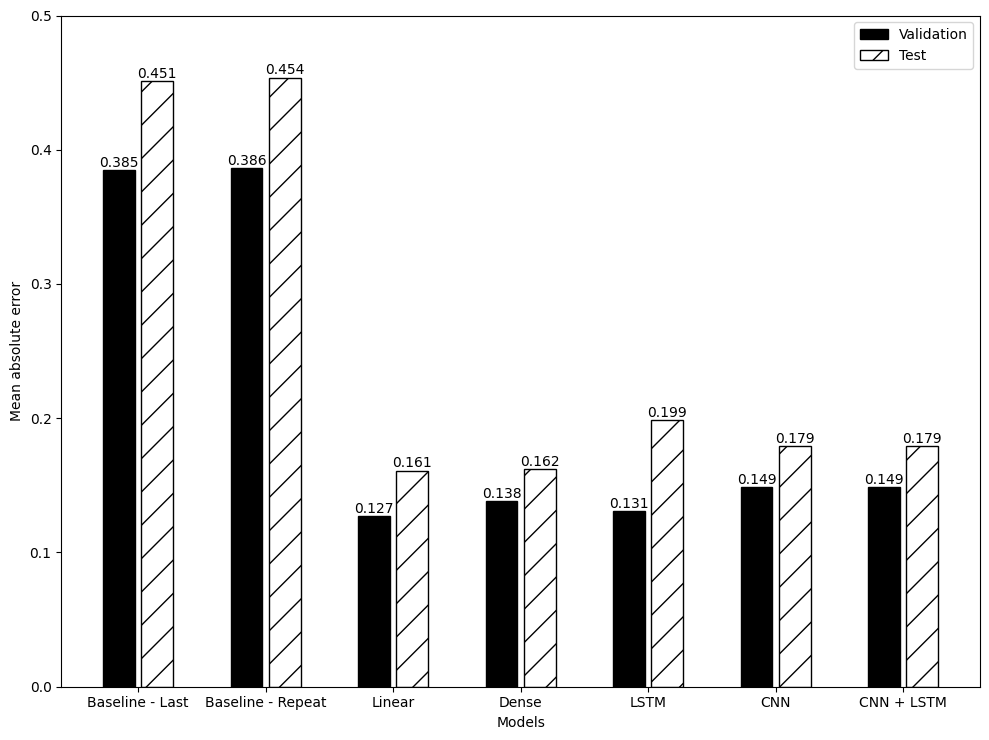

In [582]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

# 自己回帰LSTM（ARLSTM）

ARLSTMはマルチステップモデルで性能が良いとされている。
時間tの予測値の次のt+1を予測するために、時間tまでの値を使うことができる。（LSTMでは出力データの期間の結果は一気に出力されるため、自己回帰は行わない）

In [583]:
multi_window = DataWindow(input_width=30, label_width=30, shift=30, label_columns=['y'])

In [585]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [586]:
AR_LSTM = AutoRegressive(units=32, out_steps=30)

history = compile_and_fit(AR_LSTM, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0432 - mean_absolute_error: 0.2393 - val_loss: 0.0173 - val_mean_absolute_error: 0.1340
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0105 - mean_absolute_error: 0.1129 - val_loss: 0.0187 - val_mean_absolute_error: 0.1520
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0097 - mean_absolute_error: 0.1063 - val_loss: 0.0169 - val_mean_absolute_error: 0.1413
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0092 - mean_absolute_error: 0.1037 - val_loss: 0.0179 - val_mean_absolute_error: 0.1484
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0092 - mean_absolute_error: 0.1036 - val_loss: 0.0160 - val_mean_absolute_error: 0.1350
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0093 - mean_absolute_error: 0.1038 - val_loss: 0.0163 - val_mean_absolute_error: 0.1395
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0089 - mean_absolute_error: 0.1022 - val_los

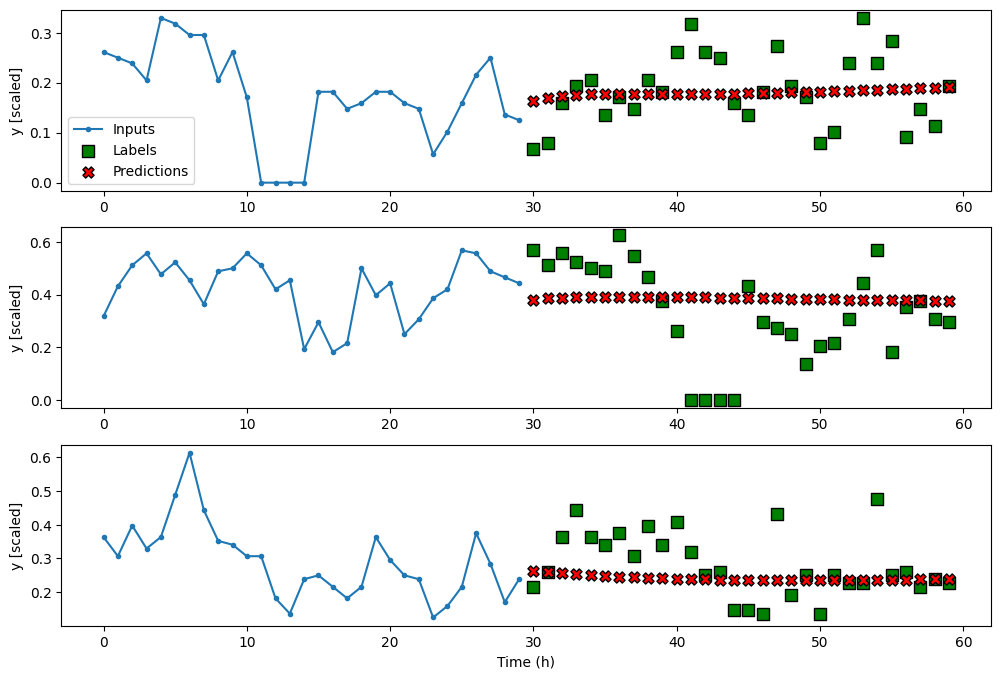

In [587]:
multi_window.plot(AR_LSTM)

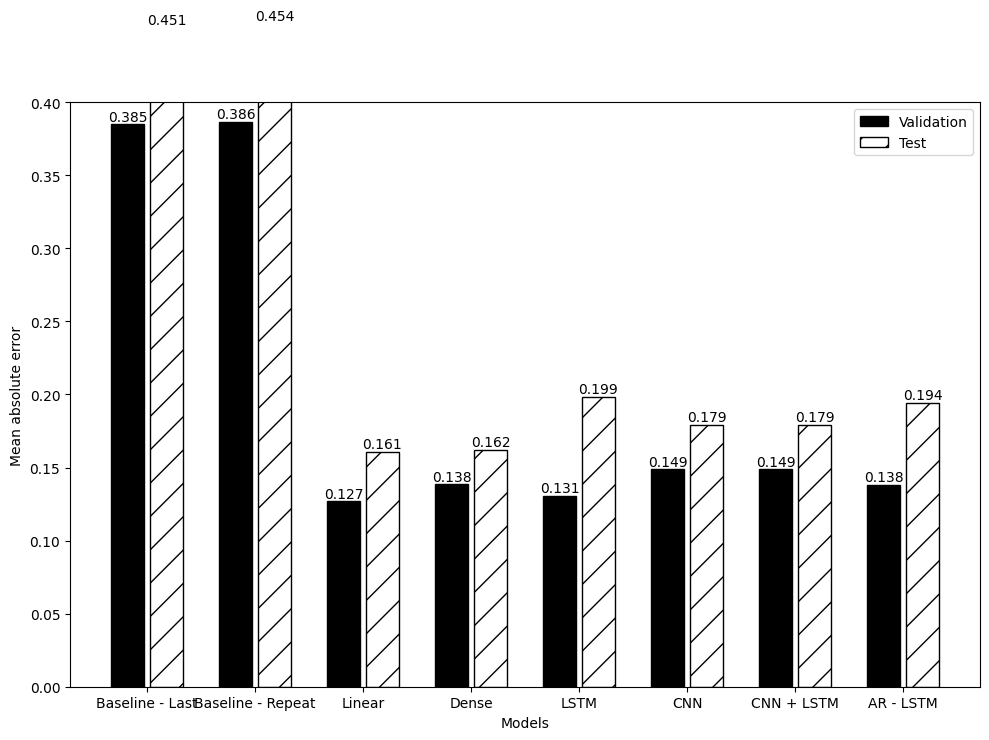

In [588]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()